This notebook is using concepts/code from these links.

https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality/notebook

https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/

In [1]:
from collections import defaultdict
from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import feature
from PIL import Image as IMG
import numpy as np
import pandas as pd 
import operator
import cv2
import os 

from IPython.core.display import HTML 
from IPython.display import Image

images_path = 'train_images/'
imgs = os.listdir(images_path)

features = pd.DataFrame()
features['image'] = imgs

In [2]:
features = features.loc[['-1.' in x for x in features.image]]

In [3]:
images_path = 'test_images/'
imgs = os.listdir(images_path)

features_test = pd.DataFrame()
features_test['image'] = imgs
features_test = features_test.loc[['-1.' in x for x in features_test.image]]

In [4]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 1000
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [5]:
def perform_color_analysis(img):

    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        light_percent1, dark_percent1 = -1, -1
        light_percent2, dark_percent2 = -1, -1

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    return dark_percent, light_percent

In [6]:
from tqdm import tqdm
tqdm.pandas()
import time

In [7]:
images_path='train_images/'

In [8]:
start=time.time()
features['dullness_whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x))
print(time.time()-start)

705.4238679409027


In [9]:
features['dullness'] = features.dullness_whiteness.map(lambda x: x[0])

In [10]:
features['whiteness'] = features.dullness_whiteness.map(lambda x: x[1])

In [11]:
topdull = features.sort_values('dullness', ascending = False)

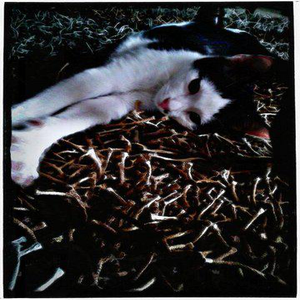

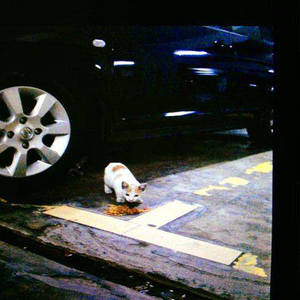

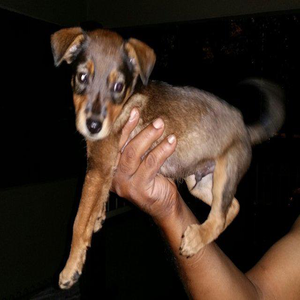

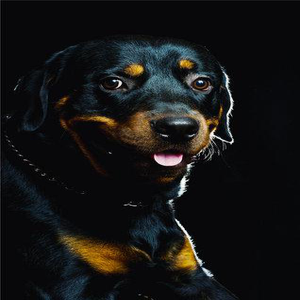

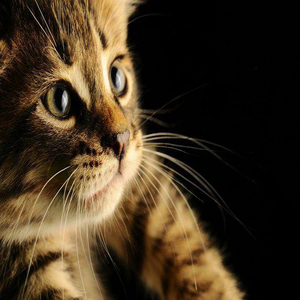

In [12]:
for j,x in topdull.head(5).iterrows():
    
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Dullness : " + str(x['dullness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

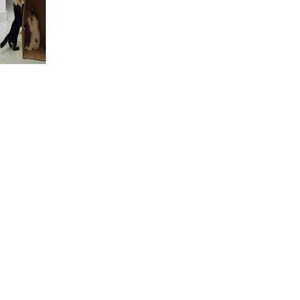

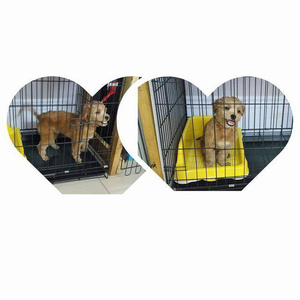

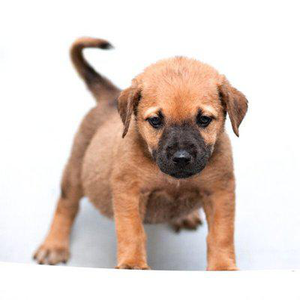

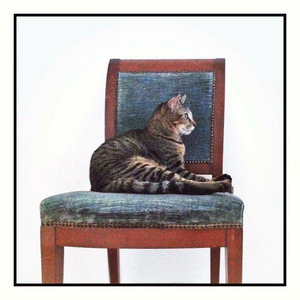

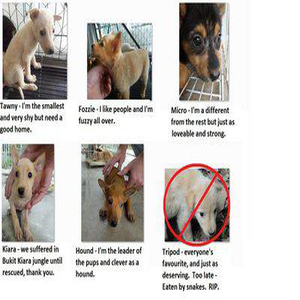

In [13]:
topbright = features.sort_values('whiteness', ascending = False)
for j,x in topbright.head(5).iterrows():
    images_path='train_images/'
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Dullness : " + str(x['dullness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [14]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [15]:
features['average_pixel_width'] = features['image'].apply(average_pixel_width)
tempdf = features.sort_values('average_pixel_width').head()
tempdf

,image,dullness_whiteness,dullness,whiteness,average_pixel_width
0,0008c5398-1.jpg,"(5.285, 0.0)",5.285,0.000,0.0
39176,ab821872c-1.jpg,"(0.0, 0.0)",0.000,0.000,0.0
39180,ab8386c6d-1.jpg,"(0.49, 22.925)",0.490,22.925,0.0
39181,ab87287a4-1.jpg,"(3.075, 22.695)",3.075,22.695,0.0
39184,ab8a8e5c9-1.jpg,"(0.0, 0.0)",0.000,0.000,0.0


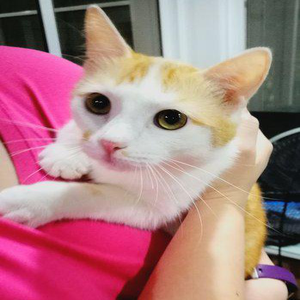

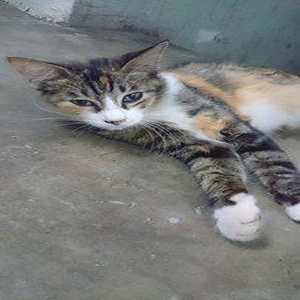

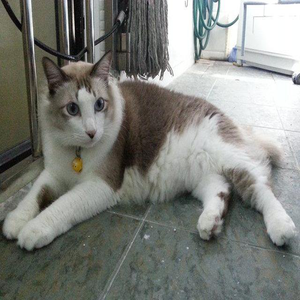

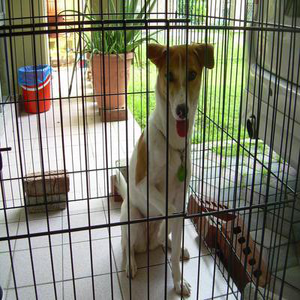

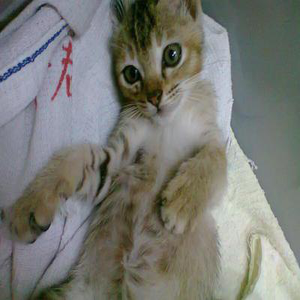

In [16]:
for j,x in tempdf.head(6).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Average Pixel Width : " + str(x['average_pixel_width']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [17]:
def getSize(filename):
    filename = images_path + filename
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    filename = images_path + filename
    img_size = IMG.open(filename).size
    return img_size 

In [18]:
features['image_size'] = features['image'].apply(getSize)
features['temp_size'] = features['image'].apply(getDimensions)
features['width'] = features['temp_size'].apply(lambda x : x[0])
features['height'] = features['temp_size'].apply(lambda x : x[1])

features.head()

,image,dullness_whiteness,dullness,whiteness,average_pixel_width,image_size,temp_size,width,height
0,0008c5398-1.jpg,"(5.285, 0.0)",5.285,0.0,0.0,23966,"(349, 479)",349,479
6,000a290e4-1.jpg,"(0.0, 0.0)",0.000,0.0,0.0,40076,"(360, 480)",360,480
8,000fb9572-1.jpg,"(28.18, 0.0)",28.180,0.0,0.0,17985,"(400, 268)",400,268
14,0011d7c25-1.jpg,"(45.615, 0.0)",45.615,0.0,0.0,22383,"(299, 400)",299,400
17,00156db4a-1.jpg,"(2.385, 0.0)",2.385,0.0,0.0,13293,"(400, 267)",400,267


In [19]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [20]:
features['blurrness'] = features['image'].apply(get_blurrness_score)

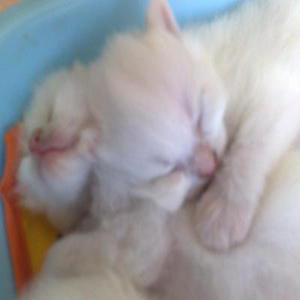

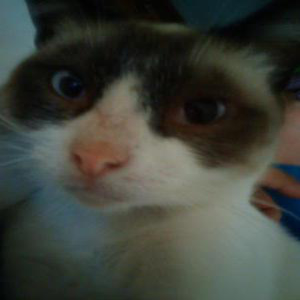

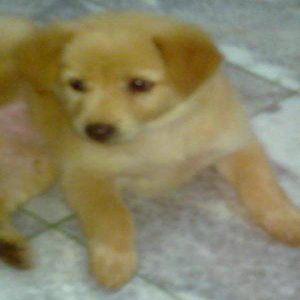

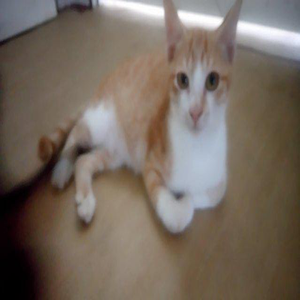

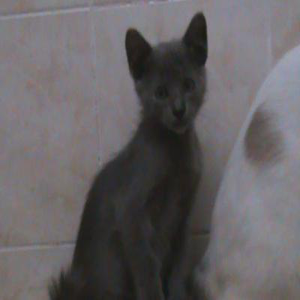

In [21]:
tempdf = features.sort_values('blurrness')
for y,x in tempdf.head(5).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Blurrness : " + str(x['blurrness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [22]:
images_path='test_images/'

In [23]:
start=time.time()
features_test['dullness_whiteness'] = features_test['image'].apply(lambda x : perform_color_analysis(x))
print(time.time()-start)

485.7432346343994


In [24]:
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

In [32]:
def image_colorfulness(image, folder):
    # split the image into its respective RGB components
    img = cv2.UMat(cv2.imread('{}/{}'.format(folder, image), cv2.IMREAD_COLOR))
    (B, G, R) = cv2.split(img)#.astype("float")
    # compute rg = R - G
    rg = np.absolute(R - G)
    
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
 
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
 
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

In [33]:
start=time.time()
features['colorfulness'] = features['image'].apply(lambda x : image_colorfulness(x, 'train_images'))
print(time.time()-start)

219.1321952342987


In [34]:
start=time.time()
features_test['colorfulness'] = features_test['image'].apply(lambda x : image_colorfulness(x, 'test_images'))
print(time.time()-start)

56.63559556007385


In [35]:
features_test['dullness'] = features_test.dullness_whiteness.map(lambda x: x[0])
features_test['whiteness'] = features_test.dullness_whiteness.map(lambda x: x[1])

In [36]:
features_test['average_pixel_width'] = features_test['image'].apply(average_pixel_width)
features_test['image_size'] = features_test['image'].apply(getSize)
features_test['temp_size'] = features_test['image'].apply(getDimensions)
features_test['width'] = features_test['temp_size'].apply(lambda x : x[0])
features_test['height'] = features_test['temp_size'].apply(lambda x : x[1])
features_test['blurrness'] = features_test['image'].apply(get_blurrness_score)

In [38]:
features.to_csv('train_image.csv',index=False)
features_test.to_csv('test_image.csv',index=False)